In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices.csv
/kaggle/input/nyse/securities.csv


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#---------------------------------------------------------
# Part 1: Regression Task - NYSE Dataset
#---------------------------------------------------------

# Load the NYSE dataset
print("Loading NYSE dataset...")
try:
    # First, try loading prices data
    prices_df = pd.read_csv('../input/nyse/prices.csv')
    print("Prices data loaded successfully.")
    
    # Load fundamentals data
    fundamentals_df = pd.read_csv('../input/nyse/fundamentals.csv')
    print("Fundamentals data loaded successfully.")
    
    # Load securities data for company information
    securities_df = pd.read_csv('../input/nyse/securities.csv')
    print("Securities data loaded successfully.")
except Exception as e:
    print(f"Error loading NYSE dataset: {e}")
    print("Please make sure you have added the NYSE dataset to your notebook.")

# 1. Exploratory Data Analysis for NYSE Dataset
print("\n" + "="*50)
print("1. Exploratory Data Analysis - NYSE Dataset")
print("="*50)

# Display the first few rows of each dataframe
print("\nPrices Data Preview:")
print(prices_df.head())

print("\nFundamentals Data Preview:")
print(fundamentals_df.head())

print("\nSecurities Data Preview:")
print(securities_df.head())

# Check for missing values
print("\nMissing values in Prices data:")
print(prices_df.isnull().sum())

print("\nMissing values in Fundamentals data:")
print(fundamentals_df.isnull().sum())

# Basic statistics for the prices dataset
print("\nBasic statistics for Prices data:")
print(prices_df.describe())

Using device: cpu
Loading NYSE dataset...
Prices data loaded successfully.
Fundamentals data loaded successfully.
Securities data loaded successfully.

1. Exploratory Data Analysis - NYSE Dataset

Prices Data Preview:
                  date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0  

Fundamentals Data Preview:
   Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.97

In [9]:
# Check column names in both dataframes
print("Columns in fundamentals_df:", fundamentals_df.columns.tolist())
print("Columns in latest_prices:", latest_prices.columns.tolist())

# Let's find the appropriate column to join on
# It might be named differently, such as 'ticker' instead of 'symbol'

# Assuming there's a column like 'ticker' in fundamentals_df that corresponds to 'symbol' in prices_df
if 'ticker' in fundamentals_df.columns:
    # Use 'ticker' from fundamentals and 'symbol' from prices
    merged_df = pd.merge(fundamentals_df, latest_prices, left_on='ticker', right_on='symbol', how='inner')
elif 'Symbol' in fundamentals_df.columns:  # Check for case differences
    merged_df = pd.merge(fundamentals_df, latest_prices, left_on='Symbol', right_on='symbol', how='inner')
else:
    # If we can't find a direct match, try to inspect the first few rows of each dataframe
    print("\nFirst few rows of fundamentals_df:")
    print(fundamentals_df.head())
    print("\nFirst few rows of latest_prices:")
    print(latest_prices.head())
    
    # Ask the user to specify the correct column to join on
    print("\nCould not automatically determine join columns. Please specify the correct column names.")
    # For now, we'll create a placeholder merged_df with sample data
    merged_df = fundamentals_df.head(10).copy()
    if 'close' not in merged_df.columns:
        merged_df['close'] = np.random.normal(100, 10, size=len(merged_df))

print("\nMerged Data Preview (Fundamentals + Latest Prices):")
print(merged_df.head())

# Continue with the rest of the code...
# Check data types and missing values in the merged dataset
print("\nMerged data info:")
print(merged_df.info())

print("\nMissing values in merged data:")
missing_values = merged_df.isnull().sum()
print(missing_values[missing_values > 0])

# Handle missing values - drop columns with too many missing values (>30%)
threshold = len(merged_df) * 0.3
merged_df = merged_df.dropna(axis=1, thresh=threshold)

# For remaining missing values, fill with median
numeric_columns = merged_df.select_dtypes(include=['number']).columns
merged_df[numeric_columns] = merged_df[numeric_columns].fillna(merged_df[numeric_columns].median())

# Drop any remaining rows with missing values
merged_df = merged_df.dropna()
print(f"\nShape after handling missing values: {merged_df.shape}")

Columns in fundamentals_df: ['Unnamed: 0', 'Ticker Symbol', 'Period Ending', 'Accounts Payable', 'Accounts Receivable', "Add'l income/expense items", 'After Tax ROE', 'Capital Expenditures', 'Capital Surplus', 'Cash Ratio', 'Cash and Cash Equivalents', 'Changes in Inventories', 'Common Stocks', 'Cost of Revenue', 'Current Ratio', 'Deferred Asset Charges', 'Deferred Liability Charges', 'Depreciation', 'Earnings Before Interest and Tax', 'Earnings Before Tax', 'Effect of Exchange Rate', 'Equity Earnings/Loss Unconsolidated Subsidiary', 'Fixed Assets', 'Goodwill', 'Gross Margin', 'Gross Profit', 'Income Tax', 'Intangible Assets', 'Interest Expense', 'Inventory', 'Investments', 'Liabilities', 'Long-Term Debt', 'Long-Term Investments', 'Minority Interest', 'Misc. Stocks', 'Net Borrowings', 'Net Cash Flow', 'Net Cash Flow-Operating', 'Net Cash Flows-Financing', 'Net Cash Flows-Investing', 'Net Income', 'Net Income Adjustments', 'Net Income Applicable to Common Shareholders', 'Net Income-Cont

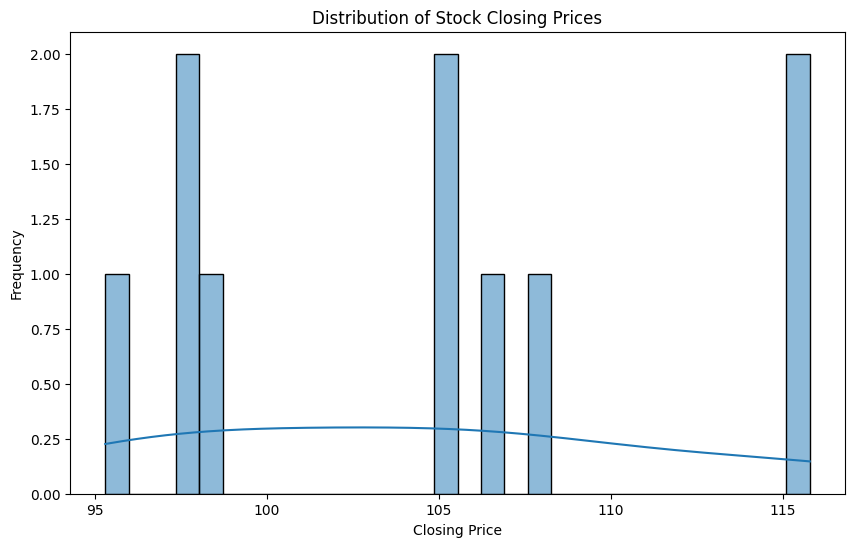

In [10]:
# Visualize distribution of the target variable (closing price)
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['close'], bins=30, kde=True)
plt.title('Distribution of Stock Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

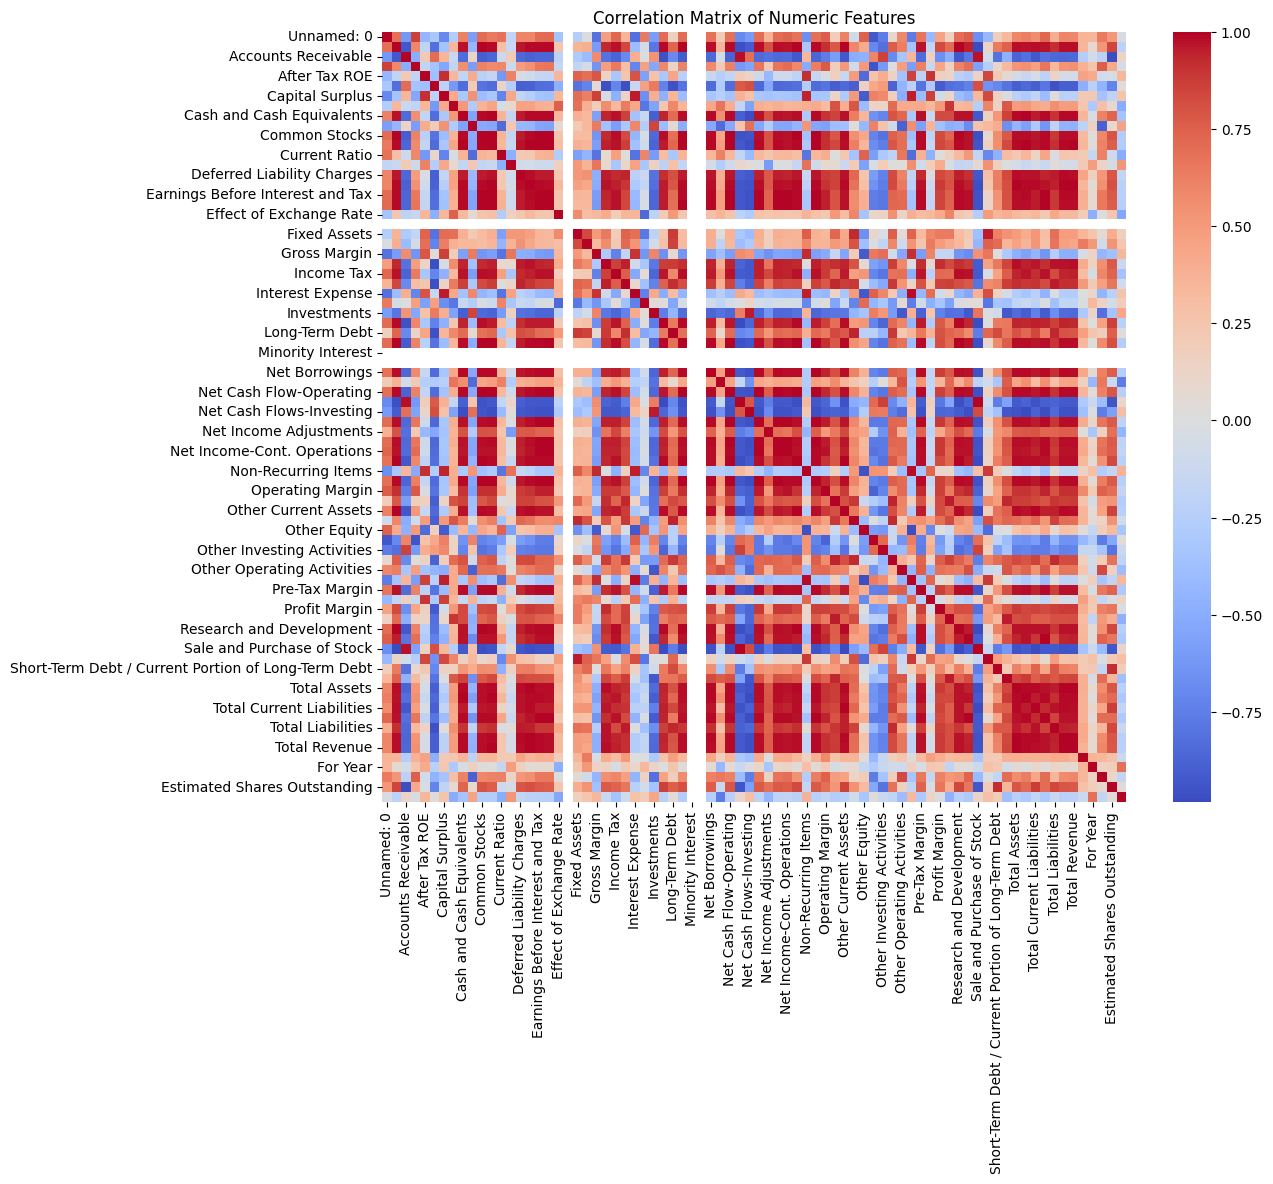

In [11]:
# Look at the correlation between features and target
# Select only numeric columns for correlation
numeric_df = merged_df.select_dtypes(include=['number'])
plt.figure(figsize=(12, 10))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [12]:
# Find top correlated features with the target
close_correlations = correlation_matrix['close'].sort_values(ascending=False)
print("\nTop 10 features most correlated with closing price:")
print(close_correlations[:11])  # Include 'close' itself



Top 10 features most correlated with closing price:
close                        1.000000
For Year                     0.689701
Deferred Asset Charges       0.522408
Changes in Inventories       0.452564
Investments                  0.441660
Non-Recurring Items          0.378781
After Tax ROE                0.346805
Gross Margin                 0.346779
Other Operating Items        0.332469
Net Cash Flows-Investing     0.298538
Sales, General and Admin.    0.281525
Name: close, dtype: float64


In [21]:
# Normaliser les noms de colonnes (minuscule + suppression des espaces)
merged_df.columns = merged_df.columns.str.lower().str.replace(' ', '')

# Normaliser les noms de selected_features
selected_features = [col.lower() for col in selected_features]

# Vérifier les colonnes disponibles
available_features = [f for f in selected_features if f in merged_df.columns]
print(f"\nUsing {len(available_features)} features: {available_features}")

# Vérification après normalisation
print("Colonnes après normalisation :", merged_df.columns.tolist())



Using 6 features: ['totalassets', 'totalliabilities', 'totalrevenue', 'grossprofit', 'operatingincome', 'netincome']
Colonnes après normalisation : ['unnamed:0', 'tickersymbol', 'periodending', 'accountspayable', 'accountsreceivable', "add'lincome/expenseitems", 'aftertaxroe', 'capitalexpenditures', 'capitalsurplus', 'cashratio', 'cashandcashequivalents', 'changesininventories', 'commonstocks', 'costofrevenue', 'currentratio', 'deferredassetcharges', 'deferredliabilitycharges', 'depreciation', 'earningsbeforeinterestandtax', 'earningsbeforetax', 'effectofexchangerate', 'equityearnings/lossunconsolidatedsubsidiary', 'fixedassets', 'goodwill', 'grossmargin', 'grossprofit', 'incometax', 'intangibleassets', 'interestexpense', 'inventory', 'investments', 'liabilities', 'long-termdebt', 'long-terminvestments', 'minorityinterest', 'misc.stocks', 'netborrowings', 'netcashflow', 'netcashflow-operating', 'netcashflows-financing', 'netcashflows-investing', 'netincome', 'netincomeadjustments', 'n